<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Seminary_UM6P_Jan_2025_Part_3_Radius_of_influence_myth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

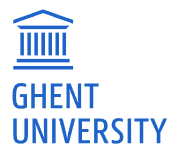<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
University Mohammed VI Polytechnic<br>
January 6, 2025<br>
Dr. Andy Louwyck

---



---

# **Part 3 - The Radius of Influence Myth**

This notebook contains some code examples to illustrate "the radius of influence myth" discussed in the third part of the presentation. The explanation provided with each example is relatively concise. If you want to get a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a full comprehension of the discussed formulas, I refer to [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 132 (delta 29), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (132/132), 6.13 MiB | 9.71 MiB/s, done.
Resolving deltas: 100% (63/63), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023).

## 1. The Sichardt formula

The Sichardt is an empirical formula to estimate the radius of influence $R$:

> $R = 3000 s_w \sqrt{K}$

with $s_w$ the drawdown (m) in the pumping well and $K$ the aquifer conductivity (m/s). Usually, the calculated radius of influence is introduced in the Thiem or the Dupuit equation to estimate the pumping rate $Q$ that is required to obtain drawdown $s_w$ in the well.

Here, we'll combine the Sichardt formula with the Thiem-Dupuit equations to simulate the cone of depression when $Q$ is given, which is a bit more challenging.

Let's get back to the running example from previous notebooks to illustrate this:

In [3]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
R  = 500     # radius of influence (m)
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
rw = 0.1     # well-radius (m)

We define the empirical Sichardt formula as a function `sichardt` using `lambda`:

In [4]:
sichardt = lambda K, sw: 3000 * sw * np.sqrt(K / 24 / 3600)

Note that conductivity `K` in the original Sichardt formula is expressed in m/s instead of m/d!

Let's calculate the radius of influence according to the Sichardt formula when the Dupuit and the Thiem equations are applied:

In [5]:
# Dupuit
from maxsypy.special import dupuit

sw = h0 - dupuit(r=rw, K=K, h0=h0, Q=Q, r_out=R)  # drawdown (m) in the well
sichardt(K, sw)  # radius (m) of influence according to Sichardt

279.08255651720174

In [6]:
# Thiem
from maxsypy.special import thiem

sw = h0 - thiem(r=rw, T=T, Q=Q, r_out=R, h_out=h0)  # drawdown (m) in the well
sichardt(K, sw)  # radius (m) of influence according to Sichardt

218.75148892163827

The problem is that the Dupuit and Thiem equations return a different drawdown `sw` in the well. For instance, check the Thiem result:

In [7]:
# drawdown sw introduced the Sichardt formule
print(sw)
# drawdown sw according to the Thiem equation using R according to Sichardt
print(h0 - thiem(r=rw, T=T, Q=Q, r_out=sichardt(K, sw), h_out=h0))

6.777766988412651
6.119922498481639


We need to find a value for `R` that gives the same result! Mathematically, we need to find the intersect of the two equations. To illustrate this, let's plot drawdown in the well `sw` as a function of radius of influence `R`. To do that, we need to rearrange the Sichardt equation as follows:

> $s_w = \dfrac{R}{3000\sqrt{K}}$

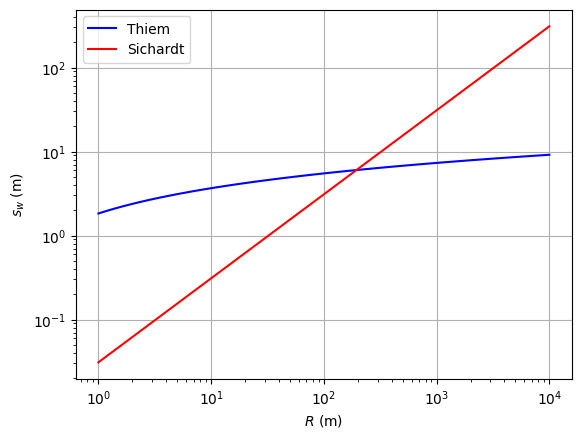

In [8]:
R = np.logspace(0, 4, 100)  # values for R
sw1 = [h0 - thiem(r=rw, T=T, Q=Q, r_out=R, h_out=h0) for R in R]  # sw according to Thiem
sw2 = [R / 3000 / np.sqrt(K / 24 / 3600) for R in R]  # sw according to Sichardt

plt.loglog(R, sw1, 'b-', R, sw2, 'r-');
plt.legend(['Thiem', 'Sichardt']);
plt.xlabel('$R$ (m)');
plt.ylabel('$s_w$ (m)')
plt.grid();

It's difficult to see the value of `R` that corresponds to the point where the two curves intersect. Fortunately, it is possible to find that value by applying an iterative solver. First, we define a function that calculates the difference between a given value for `R` and the value calculated by the Sichardt formula:

In [9]:
def func(logR):
    # logR = log10(R)
    sw = h0 - thiem(r=rw, T=T, Q=Q, h_out=h0, r_out=10**logR)
    R = sichardt(K=K, sw=sw)
    return R - 10**logR

Note that the given value is log-transformed. That's not required, but it avoids negative values for `R`.

Now it is possible to apply Scipy function `root_scalar` from module `scipy.optimize` that finds the root of a scalar function. In this case, it will find the root of function `func`, which corresponds to the case where the given value for `R` and the calculated value according to Sichardt are the same!

In [10]:
from scipy.optimize import root_scalar

result = root_scalar(func, x0=2)  # x0 is initial guess for logR
print(result)
R_sich = 10**result.root
print('R:', R_sich)

      converged: True
           flag: converged
 function_calls: 12
     iterations: 6
           root: 2.288924053159003
         method: newton
R: 194.50199183430985


Checking whether the derived value for `R` is consistent:

In [11]:
sw = h0 - thiem(r=rw, T=T, Q=Q, r_out=R_sich, h_out=h0)
print(sichardt(K=K, sw=sw))

194.5019918343098


We get the same value for `R` indeed! There are cases, however, for which it is mathematically impossible to solve the system of two equations as the Sichardt formula is not consistent with the Thiem-Dupuit equations.

As an example, consider the following parameters:

In [25]:
K = 1 # m/d
h0 = 10 # m
T = K * h0 # m²/d
Q = -1 # m³/d
rw = 0.1 # m

In this case, the Sichardt curve (red) and the Thiem curve (blue) do not intersect. This means there is no mathematical solution, although the given parameters are realistic!

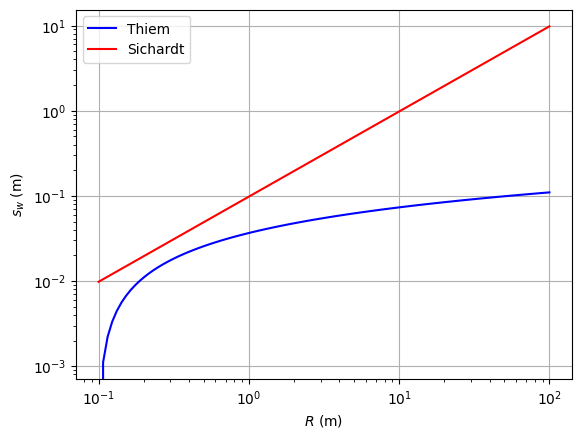

In [26]:
R = np.logspace(np.log10(rw), 2, 100)  # values for R
sw1 = [h0 - thiem(r=rw, T=T, Q=Q, r_out=R, h_out=h0) for R in R]  # sw according to Thiem
sw2 = [R / 3000 / np.sqrt(K / 24 / 3600) for R in R]  # sw according to Sichardt

plt.loglog(R, sw1, 'b-', R, sw2, 'r-');
plt.legend(['Thiem', 'Sichardt']);
plt.xlabel('$R$ (m)');
plt.ylabel('$s_w$ (m)')
plt.grid();

This example illustrates that the Sichardt formula is non consistent with fundamental hydrogeological principles indeed! Moreover, it may underestimate the extent of the cone of depression.

## 2. Alternatives

The previous notebook discussed well-known one-dimensional axisymmetric models that provide alternative formulas to estimate the radius of influence:

- de Glee (1930)
- Theis (1935)
- Hantush-Jacob (1955)
- Ernst (1971)

As these formulas are consistent with fundamental hydrogeological principles, they are better alternatives to the empirical Sichardt formula.

---